In [49]:
from psaw import PushshiftAPI
import datetime
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import requests
from collections import Counter
import io 
import networkx as nx ; import netwulf as nw
from datetime import datetime, timezone, date
import datetime as dt
from netwulf import visualize
from networkx import Graph
import random
import shifterator as sft
import networkx.algorithms.community as nx_comm
from community import community_louvain
from ast import literal_eval
tqdm.pandas()

C:\Users\JaQtae\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [39]:
def setup_mpl():
    #mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '15'
    mpl.rcParams['lines.linewidth'] = 3
setup_mpl()

# 1. Motivation

## The datasets

### The Reddit dataset

For this project, we chose to work with data from the [r/politics](https://www.reddit.com/r/politics/) subreddit, an online forum with 8 million members "for current and explicitly political U.S. news." according to the rules stated on the site. 

Visitors at r/politics will quickly notice that the majority of the submissions are by users posting links to news articles published on news media sites like CNN or The Huffington Post. The headlines of these linked articles are then shown on r/politics as the titles of the submissions. Other users can then comment on the linked article, which is what ultimately constitutes the actual user-generated content on the site. 

We focused our data extraction to only include submissions from r/politics that fulfilled the following criteria: 
* __They contained "Trump" or "Biden" in the title.__ While submissions containing other words and names than "Trump" and "Biden" (e.g. "Republican" and "Democrat") might be used to provide equally good indications of the political convictions of redditors, this textual query allowed us to limit the scope of the project while still extracting data essential to the aim of this project. 
* __They had received more than five comments.__ This requirement was to prevent us from downloading submissions with no or only a very small comments section, as we'll be using the comments to conduct the later sentiment analysis and produce a partitioning of the redditors. 
* __They had been published between 10-1-2020 and 11-2-2020.__ This period covered approximately a month before the most recent U.S. presidential election that took place on 11-3-2020. Ideally, we would have covered several months leading up to the election day, in order to detect longer term trends in the data. However, that would prove to be computationally infeasible, given the amount of data this would yield. 

__Submission variables__

The downloaded submissions would be structured in a Pandas dataframe containing the following variables for each submission in its respective columns: 
1. __Time stamp:__ Simply stating when the submissions was made.
2. __Title:__ Being the title of the submission. Usually the header of the linked article. 
3. __ID:__ A unique identifier for a particular submission. 
4. __Author:__ The profile name of the author of the submissions.
5. __Number of comments:__ The number of comments received on the particular submission.
6. __URL:__ The link stated in the text of the submission.

Our query to extract comments from the r/politics subreddit was also focused to only include comments fulfilling the following criteria: 
* __They were related to one of the downloaded submissions.__ 
* __They were posted no later than 11-10-2020.__ By including comments posted up to one week after the election day, we would ensure that we would also have some comments for any submissions made on the day before the election day, without including comments that were made way after the objective period, which would not be representative of the sentiment during the objective period. 

__Comments variables__

As stated, we would download the associated comments section for all the downloaded submissions. Similarly to the submissions, the comments would be structured in a Pandas dataframe containing the following variables for each comment in its respective columns:
1. __time stamp index:__ Simply stating when the submissions was made.
2. __id:__ A unique identifier for a particular submission. 
3. __link_id:__ A unique identifier for the original submission to which the comment relates, somewhere in the comments section.
4. __author:__ The profile name of the author of the submissions.
5. __parent_id:__ A unique identifier for the post to which the comment was made. This may either be a submission or a comment, which is indicated with with the parent_id starting with either "t3_" or "t1_".
6. __body:__ The textual content of the comment. 


__Reasons for choosing this particular data set__ <br>
1. Easy to collect using the Pushshift API.
2. Interesting topic that would fit the requirements of the project.
3. Similar format as the data we've previously worked with.

### The polling dataset
The polling data used in this project is collected from [FiveThirtyEight](https://data.fivethirtyeight.com/). 
The data set contains polling results from our objective period, generated by different polling firms like YouGov and SurveyMonkey. Each poll has been generated over a smaller time window, typically spanning a couple of days, and with varying number of respondents. By the end of the polls, the percentage of respondents who have voted for a specific candidate has been registered. We have not investigated further how the individual polling firms have performed the polls, but we put our faith in their ability to make polls representative of the American population. 


### Goal for end user's experience
Our goal is for the end user's of our website to find the results of our analyses interesting.


### Downloading the Reddit data

In [ ]:
api = PushshiftAPI()

my_subreddit = "politics"
query = "Trump | Biden "

date1 = int(datetime.datetime(2020,10,1).timestamp())
date2 = int(datetime.datetime(2020,11,3).timestamp())

gen = api.search_submissions(num_comments= '>5',
                             subreddit=my_subreddit, 
                             after=date1, 
                             before=date2, 
                             q=query
                            )
results = list(gen)

In [49]:
column_names = ['title', 'id', 'author', 'num_comments', 'url']

sub_data = pd.DataFrame(
    {
        column_names[0] : [submission.d_[column_names[0]] for submission in results],
        column_names[1] : [submission.d_[column_names[1]] for submission in results],
        column_names[2] : [submission.d_[column_names[2]] for submission in results],
        column_names[3] : [submission.d_[column_names[3]] for submission in results],
        column_names[4] : [submission.d_[column_names[4]] for submission in results]
    },
    index = [submission.d_['created_utc'] for submission in results])
sub_data.index = pd.to_datetime(sub_data.index, unit='s')

To ensure that each submissions is unambigously related to either one of the candidates, we simply remove all submissions containing both "Trump" and "Biden". 

In [51]:
# List to contain indices of subs in df with a title containing both "Trump" and "Biden"
TB = []
for i in range(len(sub_data['title'])):
    if (re.search('Trump', sub_data['title'][i])) and (re.search('Biden', sub_data['title'][i])):
        TB.append(i)
    else:
        continue
        
sub_data = sub_data.drop(sub_data.index[TB])

Now we're ready to download the associated comments sections for each of the remaining submissions. 

In [ ]:
date3 = int(datetime.datetime(2020,11,10).timestamp())

comments = []
for link_id in tqdm(subs_df['id']):
    gen = api.search_comments(subreddit=my_subreddit,
                              link_id=link_id,
                              before=date3)
    comment_sec = list(gen)
    comments += comment_sec

In [500]:
column_names = ['id', 'link_id', 'author', 'parent_id', 'body']

com_data = pd.DataFrame(
    {
        column_names[0] : [comment.d_[column_names[0]] for comment in comments],
        column_names[1] : [comment.d_[column_names[1]] for comment in comments],
        column_names[2] : [comment.d_[column_names[2]] for comment in comments],
        column_names[3] : [comment.d_[column_names[3]] for comment in comments],
        column_names[4] : [comment.d_[column_names[4]] for comment in comments]
    },
    columns= column_names, index = [comment.d_['created_utc'] for comment in comments])

com_data.index = pd.to_datetime(com_data.index, unit='s')
# This cell is to ensure that the "body" column of the comments data only contains strings
com_data["body"] = com_data["body"].astype("str")

# 2. Cleaning, preprocessing and stats

### Processing the submissions

__Determining the mentioned politician__<br>
We need to determine whether the collected submissions are relating to either Trump or Biden, as we have already removed all the submissions including both names. We do this simply by searching the title of the submissions for these names and adding a "politician" variable to each submission stating which of the politians are mentioned. 

In [ ]:
def determine_politician_subs(title):
        if (re.search('Trump', title)):
            return 'Trump'
        else:
            return 'Biden'
tqdm.pandas()
sub_data['politician'] = sub_data['title'].progress_apply(determine_politician_subs)

### Cleaning and preprocessing the comments


__Removing deleted comments__<br>
Some of the comments have been removed after being posted, so we'll do some cleaning first by filtering out the comments where author = "[deleted]", which will do the job. Similarly, we found that a large part of the comments were made by moderator robots reminding real redditors to behave in accordance with the subreddit rules. Comments made by these bots are also removed. 

In [12]:
com_data = com_data.drop(com_data[com_data['author'] == '[deleted]'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'AutoModerator'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'PoliticsModeratorBot'].index)

__Removing comments by authors with less than 50 comments__<br>
We also remove all comments by authors who have posted less than 50 comments in total. The reason for this being that we would like to have a more solid foundation on which to infer the political convictions of the redditors, which would not be achieved if we had only very few comments made by them.

In [13]:
com_data = com_data.groupby('author').filter(lambda x : len(x)>=50)

__Finding parent authors for the comments__<br>
To later build our network of redditors, we will populate the comments dataframe with the names of the parent authors.
This will create some [deleted] and NaN values which we will delete.

In [14]:
comment_authors = dict(zip(com_data.id, com_data.author))
parent = dict(zip(com_data.id, com_data.parent_id))
submission_authors = dict(zip(sub_data.id, sub_data.author))

In [15]:
def find_parent_author(comment_id):
    parent_id = parent[comment_id]    
    
    if parent_id[:3] == 't1_':
        return comment_authors.get(parent_id[3:], None)
    
    elif parent_id[:3] == 't3_':
        return submission_authors.get(parent_id[3:], None)

com_data["parent_author"] = com_data.id.apply(find_parent_author)
com_data = com_data.drop(com_data[com_data['parent_author'] == '[deleted]'].index) # Remove deleteds
com_data = com_data.drop(com_data[com_data['parent_author'].isna()].index) # Remove NaN's

__Tokenization__ <br>
As we will also be looking into producing other textual analyses than the VADER sentiment scores, like wordclouds, we will also need to do some tokenization ourselves. 
For the body of each comment, we will do the following steps: 
   * Exclude punctuation.
   * Exclude URLs
   * Exclude English stop words
   * Exclude numbers.
   * Set everything to lower case. 
   
The results of this preprocessing will be a new column in the comments dataframe containing the cleaned tokens of the text body. 

In [ ]:
# Define stop words to also include punctuation
stop = set(stopwords.words('english') + list(string.punctuation))
# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

com_data["tokens"] = com_data.progress_apply(lambda x: clean_tokens(x["body"]), axis=1)

__Determining whether the comments are "Trump" or "Biden" -related__ <br>
For each of the collected comments, we need to know whether the comment relates to Trump or Biden. Our plan to achieve this is to first assign a "politician" variable to all comments that matches the "politician" value of the submission to which the comments was made. 

In [ ]:
def determine_politician_coms(link_id):
    #Get the id of the original submission
    real_id = link_id[3:]   
    # Find the politician value of the corresponding submission
    sub_politician = sub_data.loc[sub_data['id'] == real_id]['politician']
    sub_politician = sub_politician.values[0]
    return sub_politician 
com_data['politician'] = com_data['link_id'].progress_apply(determine_politician_coms)

This assignment of "politician" values i very naive, as it does not take into account the possibility of the actual comments mentioning either of the politicians. To overcome this, we will prune the comments section tree so that whenever a comment mentions a different politician than what is currently stated as its "politician" value, we will remove this comment along with all comments made to that comment - the so-called children of the comment. This way, we ensure an unambiguous picture of which politician each comment relates to. 

This procedure requires us to also know the children of each comment, which find below:

In [ ]:
# A list of all the id's in the comments datafram
com_ids = list(com_data['id'].values)

# We create a dictionary with keys equal to the id's in of the comments and values equal to their respective "children" comments
children_dict = {com_id: [] for com_id in com_ids}

for com_id in tqdm(com_ids): 
    parent_id = com_data.loc[com_data['id'] == com_id]['parent_id']
    parent_id = parent_id.values[0]
    parent_id = parent_id[3:]
    if parent_id in com_ids: 
        children_dict[parent_id].append(com_id)

In [ ]:
# Append the children comments to the comments dataframe
def determine_children(com_id):
    return children_dict[com_id]    

com_data['children_comments'] = com_data['id'].progress_apply(determine_children)

Now we will figure out whether each comment itself mentions "Trump" or "Biden". 

In [ ]:
def comment_mentions_Trump(com_id):
    mentions_Trump = False
    tokenized_body = " ".join(com_data.loc[com_data['id'] == com_id]['tokens'].values[0])
    if (re.search('trump', tokenized_body)):
        mentions_Trump = True
        return mentions_Trump
    
def comment_mentions_Biden(com_id):
    mentions_Biden = False
    tokenized_body = " ".join(com_data.loc[com_data['id'] == com_id]['tokens'].values[0])
    if (re.search('biden', tokenized_body)):
        mentions_Biden = True
        return mentions_Biden
    
com_data['mentions_Trump'] = com_data['id'].progress_apply(comment_mentions_Trump)
com_data['mentions_Biden'] = com_data['id'].progress_apply(comment_mentions_Biden)

In [24]:
comments_to_delete = []

# Function to find the comments to be deleted due to amgious politician relation. 
def find_coms_to_be_deleted(com_id):

    if com_id not in comments_to_delete: 
        mentions_Biden = com_data.loc[com_data['id'] == com_id]['mentions_Biden']
        mentions_Biden = mentions_Biden.values[0]

        mentions_Trump = com_data.loc[com_data['id'] == com_id]['mentions_Trump']
        mentions_Trump = mentions_Trump.values[0]

        politician = com_data.loc[com_data['id'] == com_id]['politician']
        politician = politician.values[0]

        children = com_data.loc[com_data['id'] == com_id]['children_comments']
        children = children.values[0]

        if (politician == 'Biden' and mentions_Trump) or (politician == 'Trump' and mentions_Biden): 

            comments_to_delete.append(com_id)

            if len(children): 
                for child in children:
                    comments_to_delete.append(child)
                    find_coms_to_be_deleted(child)

In [ ]:
for com_id in tqdm(com_ids): 
    find_coms_to_be_deleted(com_id)

In [ ]:
comments_to_delete= list(set(comments_to_delete))
for com_id in tqdm(comments_to_delete):
    com_index = com_data.id[com_data.id == com_id].index
    com_data = com_data.drop(com_index)

# Delete cell below before uploading

In [3]:
# Loading the processed comments data set
com_data = pd.read_csv(r"C:\Users\JaQtae\Desktop\SocInfo2022\FINAL_COMMENTS.csv", parse_dates = ['dates'], sep=',', converters={'tokens': literal_eval} ).set_index("dates")
# This cell is to ensure that the "body" column of the comments data only contains strings
com_data["body"] = com_data["body"].astype("str")

#sub_data = pd.read_csv(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\GitHub New\SocInfo2022\Data\SUBS_FINAL.csv", parse_dates = ['dates'], sep=',').set_index("dates")

### Statistics of the submissions

We'll look into the distribution of the submissions mentioning either Trump or Biden. 

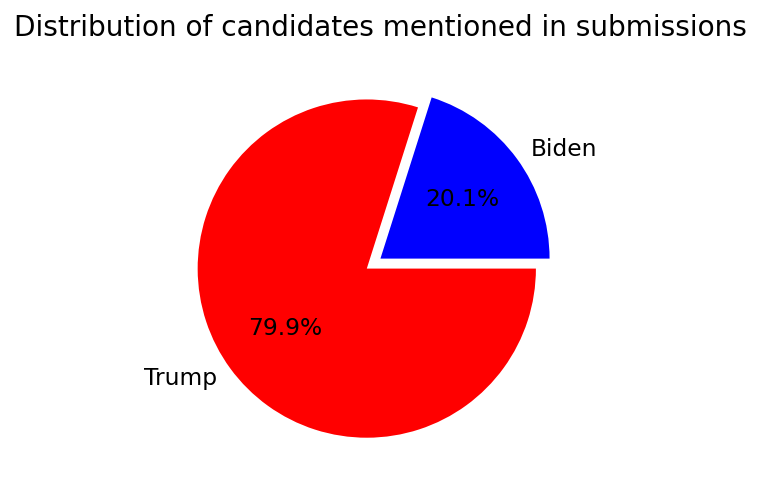

In [52]:
biden_trump_subs_dist = pd.DataFrame(sub_data.groupby("politician").count()["title"])
biden_trump_subs_dist = biden_trump_subs_dist.rename(columns = {"title" : " "})
#biden_trump_subs_dist
fig = plt.figure(dpi=140)
subs_dist_plot = biden_trump_subs_dist.plot.pie(y = " ", title = "Distribution of candidates mentioned in submissions", legend = False, colors = ["blue", "red"], shadow = False, autopct='%1.1f%%', explode=(0, 0.1), ax=plt.gca())
subs_dist_plot.figure.savefig(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\subs_distribution_NEW_2.svg", bbox_inches='tight',  dpi=400)

In [26]:
print("Total number of submissions: " + str(len(sub_data)))
print("Total number of submissions mentioning Trump: " + str(len(sub_data.loc[sub_data["politician"] == "Trump"])))
print("Total number of submissions mentioning Biden: " + str(len(sub_data.loc[sub_data["politician"] == "Biden"])))
print("Number of unique authors: " + str(len(sub_data["author"].unique())))
print("Average number of submissions per author: " + str(round(sub_data.groupby("author").count()["title"].mean(),2)))
print("Average number of comments per submission: " + str(round(sub_data["num_comments"].mean(), 1)))

Total number of submissions: 9018
Total number of submissions mentioning Trump: 7205
Total number of submissions mentioning Biden: 1813
Number of unique authors: 2912
Average number of submissions per author: 3.1
Average number of comments per submission: 150.5


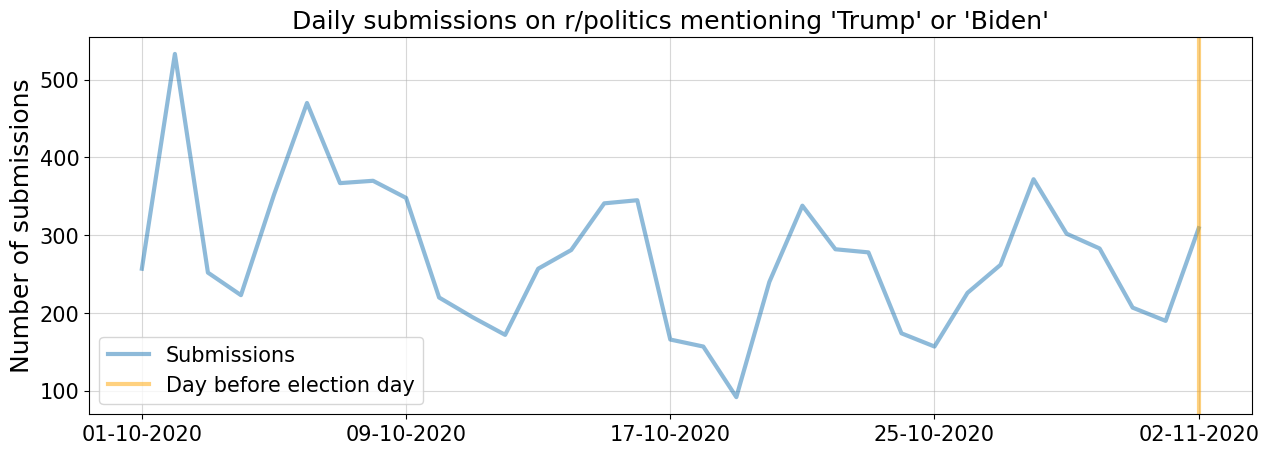

In [35]:
sub_data = sub_data[sub_data.index > "2020-10-01"]
daily_subs = sub_data['id'].resample('D').count()
MyFmt = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
#Convert to dataframe
daily_subs_df = pd.DataFrame(
                    {
                        'Daily submissions' : daily_subs.values
                    }, index = daily_subs.index)

MA_subs = daily_subs_df["Daily submissions"].rolling('3D').mean()
#Plot the moving average on top!

#fig, ax = plt.subplots(figsize=(15,5), dpi=400)
fig, ax = plt.subplots(figsize=(15,5), dpi=100)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.plot(daily_subs.index, daily_subs.values, alpha=0.5, label="Submissions")
#ax.plot(MA_subs.index, MA_subs.values, color='k', label="3-day rolling average")
#ax.locator_params(axis='x', nbins=5)
ax.axvline(x=daily_subs.index[-1], label='Day before election day', color='orange', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Number of submissions', size = 18)
#ax.set_yscale('log')
ax.legend()
plt.grid(True, alpha=0.5)
ax.xaxis.set_major_formatter(MyFmt)
plt.title("Daily submissions on r/politics mentioning 'Trump' or 'Biden'")

plt.savefig(r'C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\submissions_per_day_new.svg', bbox_inches='tight', dpi=400)

### Statistics of the comments

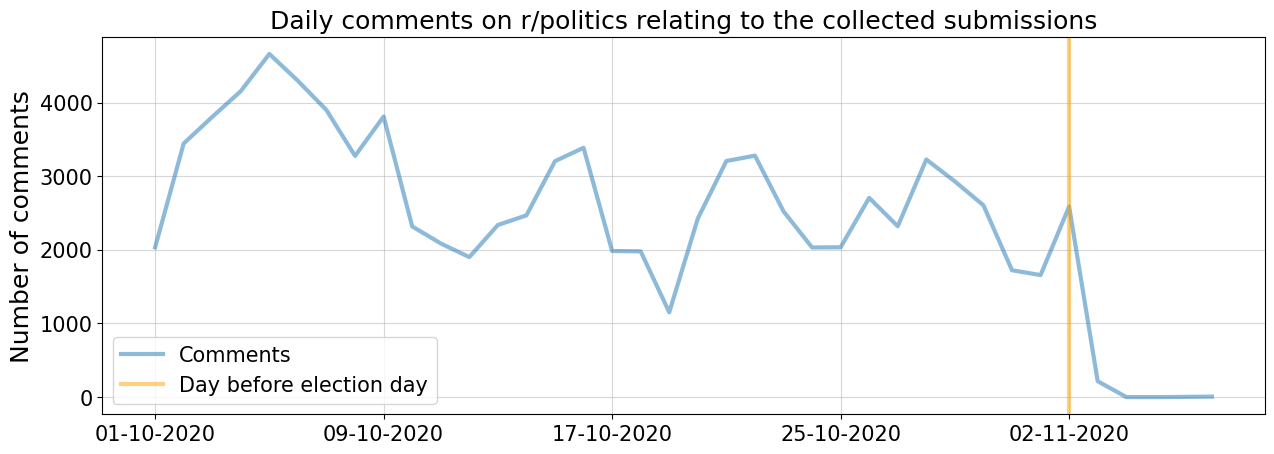

In [37]:
daily_coms = com_data['id'].resample('D').count()
MyFmt = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
#Convert to dataframe
daily_coms_df = pd.DataFrame(
                    {
                        'Daily comments' : daily_coms.values
                    }, index = daily_coms.index)

MA_coms = daily_coms_df["Daily comments"].rolling('3D').mean()
#Plot the moving average on top!

#fig, ax = plt.subplots(figsize=(15,5), dpi=400)
fig, ax = plt.subplots(figsize=(15,5), dpi=100)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.plot(daily_coms.index, daily_coms.values, alpha=0.5, label="Comments")
#ax.plot(MA_subs.index, MA_subs.values, color='k', label="3-day rolling average")
#ax.locator_params(axis='x', nbins=5)
ax.axvline(x=daily_subs.index[-1], label='Day before election day', color='orange', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Number of comments', size = 18)
#ax.set_yscale('log')
ax.legend()
plt.grid(True, alpha=0.5)
ax.xaxis.set_major_formatter(MyFmt)
plt.title("Daily comments on r/politics relating to the collected submissions")

plt.savefig(r'C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\comments_per_day_new.svg', bbox_inches='tight', dpi=400)

In [7]:
print("Total number of comments: " + str(len(com_data)))
print("Average length of comments: " + str(com_data['body'].apply(len).mean()))
print("Total number of comments related to Trump: " + str(len(com_data.loc[com_data["politician"] == "Trump"])))
print("Total number of comments related to Biden: " + str(len(com_data.loc[com_data["politician"] == "Biden"])))
print("Number of unique comment authors: " + str(len(com_data["author"].unique())))
print("Average number of comments per author: " + str(round(com_data.groupby("author").count()["id"].mean(),2)))
#print("Average number of comments per submission: " + str(round(com_data["num_comments"].mean(), 1)))

Total number of comments: 91672
Average length of comments: 138.2530325508334
Total number of comments related to Trump: 77030
Total number of comments related to Biden: 14642
Number of unique comment authors: 1553
Average number of comments per author: 59.03


### Statistics of polling data

In [42]:
url = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/president_polls_historical.csv"

download_poll = requests.get(url).content

poll_data = pd.read_csv(io.StringIO(download_poll.decode('utf-8')), parse_dates = ['end_date'], sep=',').set_index('end_date')

poll_data.index = poll_data.index.rename('dates')
poll_data = poll_data.loc[poll_data.index >= "2020-10-01"]
poll_data_reduced = poll_data[['candidate_name','pct']]

poll_data_biden = poll_data_reduced.loc[poll_data_reduced['candidate_name'] == 'Joe Biden']
poll_data_biden_daily_mean = poll_data_biden['pct'].resample('D').mean()

poll_data_trump = poll_data_reduced.loc[poll_data_reduced['candidate_name'] == 'Donald Trump']
poll_data_trump_daily_mean = poll_data_trump['pct'].resample('D').mean()

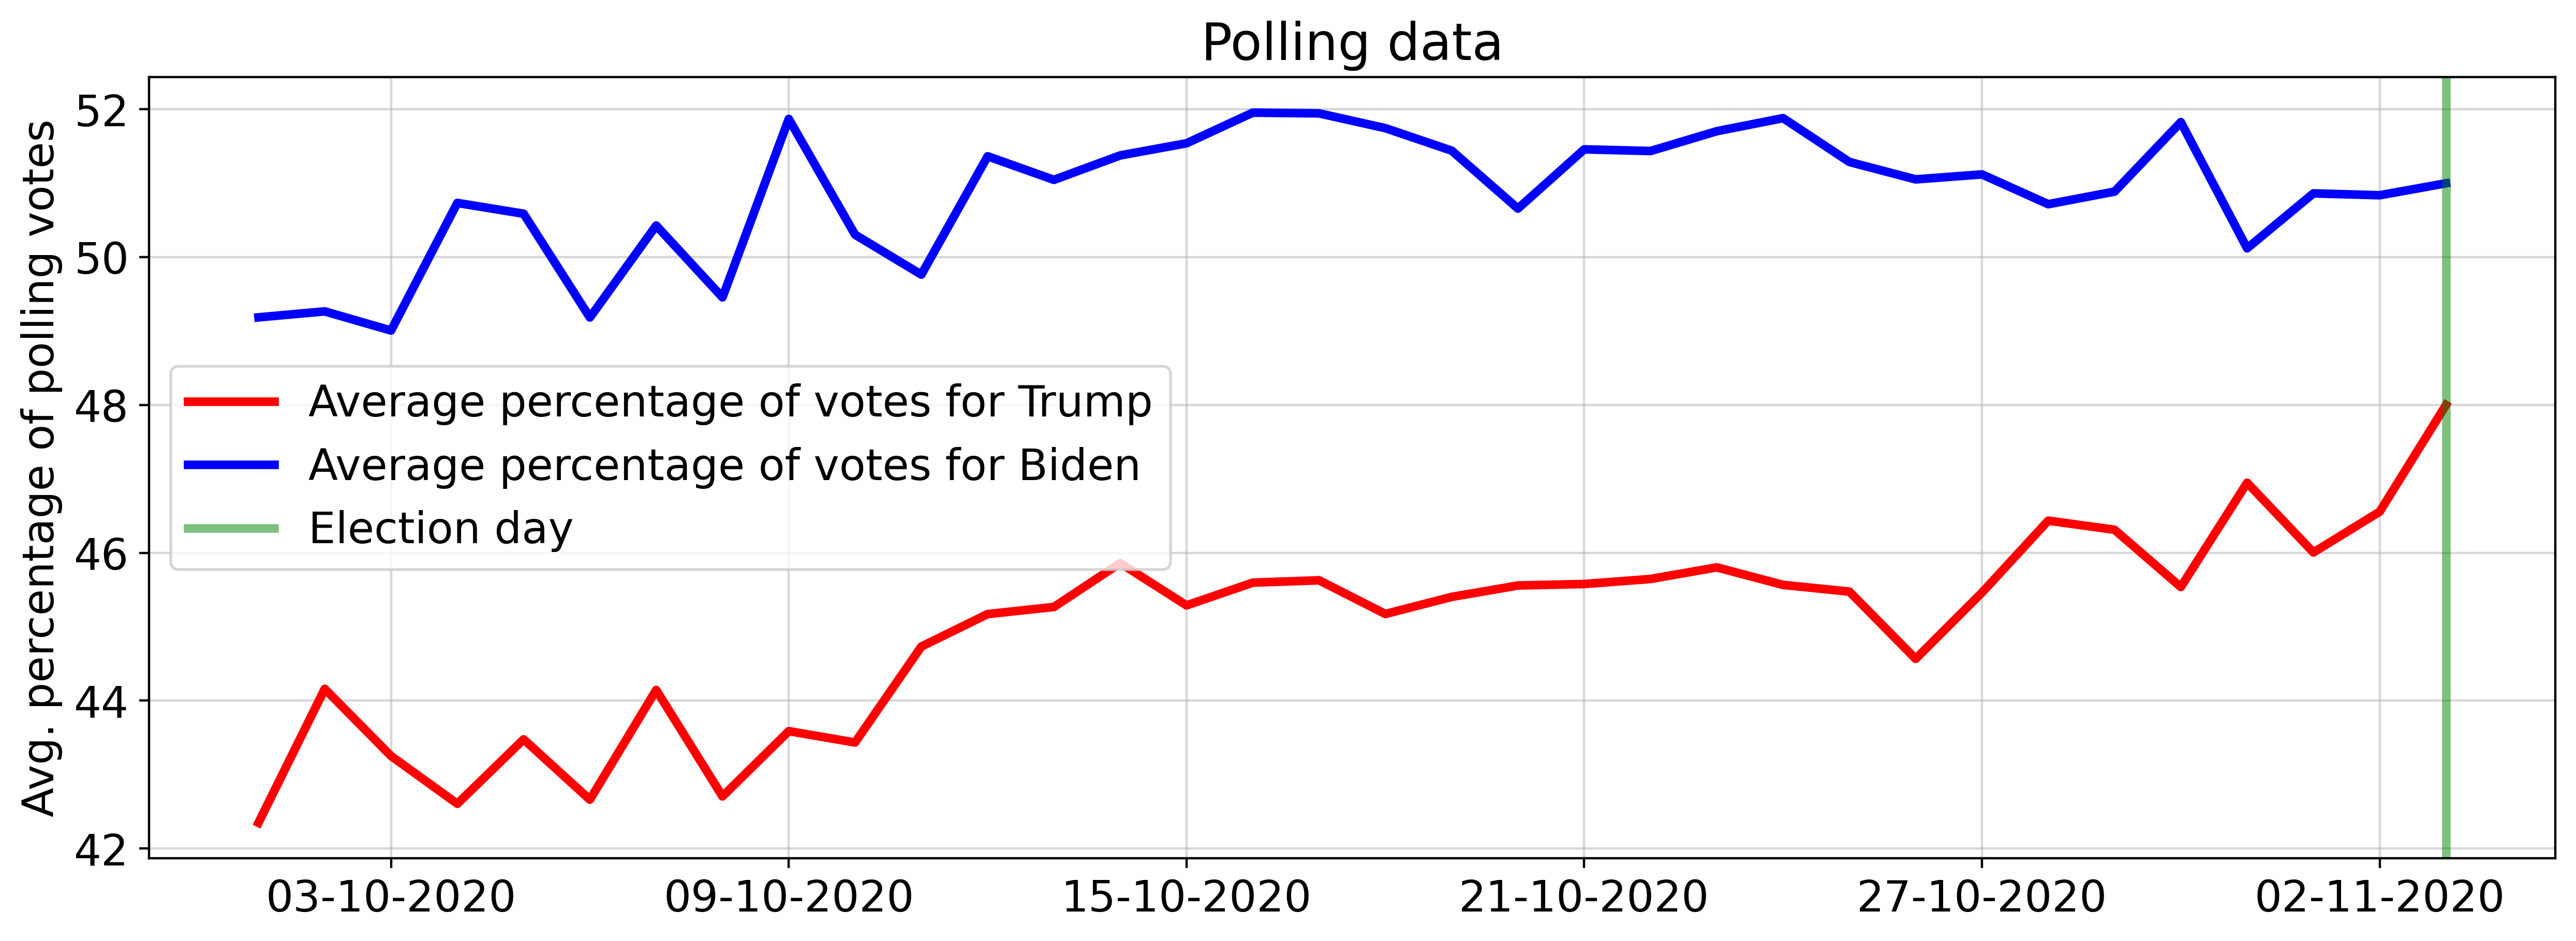

In [45]:
MyFmt = mdates.DateFormatter('%d-%m-%Y')

poll_data_trump_daily_mean_df = pd.DataFrame(
                    {
                        'Poll pct' : poll_data_trump_daily_mean.values
                    }, index = poll_data_trump_daily_mean.index)

MA_poll_data_trump = poll_data_trump_daily_mean_df["Poll pct"].rolling('3D').mean()

poll_data_biden_daily_mean_df = pd.DataFrame(
                    {
                        'Poll pct' : poll_data_biden_daily_mean.values
                    }, index = poll_data_biden_daily_mean.index)

MA_poll_data_biden = poll_data_biden_daily_mean_df["Poll pct"].rolling('3D').mean()

fig, ax = plt.subplots(figsize=(15,5), dpi=400)
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
ax.plot(poll_data_trump_daily_mean.index, poll_data_trump_daily_mean.values, color = 'r', alpha=1, label="Average percentage of votes for Trump")
ax.plot(poll_data_biden_daily_mean.index, poll_data_biden_daily_mean.values, color = 'blue', alpha=1, label="Average percentage of votes for Biden")
ax.axvline(x=poll_data_trump_daily_mean.index[-1], label='Election day', color='green', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Avg. percentage of polling votes')
#ax.set_yscale('log')
plt.grid(True, alpha=0.5)
ax.legend()
ax.xaxis.set_major_formatter(MyFmt)
plt.title("Polling data")
plt.savefig(r'C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\polling_data.svg', bbox_inches='tight', dpi=400)

# 3. Tools, theory and analysis

## Working with text

We wanted to use the text in the downloaded comments dataset for two reasons: 
1. To compute the daily sentiment for Biden and Trump and investigate whether there would be any interesting differences between the words used in Biden- and Trump-related comments respectively. 
2. To create a binary partitioning of the comment authors based on their expressed sentiment towards the two presidential candidates. 

We chose to work with two different dictionary-based sentiment scoring methods. To compute the daily sentiment for Biden and Trump, which we would compare with the collected polling data, we used the [Hedonometer word list data](https://hedonometer.org/words/labMT-en-v1/), which basically is a huge collection of words with associated average happiness scores as judged by people on Amazon's Mechanical Turk. To create the binary partioning of the comment authors, we used the similar Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53)) module from the nltk.sentiment library, which has been specifically created to work with text produced on social media. One of the great features of this module is that it is quite robust in terms of the needed data cleaning and processing to function properly. Typical processing steps like tokenization and stemming as well as removing stop words are consequently not required to have the VADER module work well and provide an indication of the sentiment of a body of text. 


### 1. Computing the daily sentiment for Biden and Trump. 

__Grouping the data by the associated politician and make it into a single corpus__

In [26]:
author_bodies = com_data.groupby(["politician"]).apply(lambda x: x["body"].unique())
trump_corpus = " ".join(author_bodies["Trump"])
biden_corpus = " ".join(author_bodies["Biden"])
#com_data["tokens"]

In [27]:
# We solve this by defining the clean_tokens function below.
# Define stop words to also include punctuation
import nltk
stop = set(stopwords.words('english') + list(string.punctuation))

# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    # In the list comprehension below, we exclude URL's, stopwords and numbers as well as setting all characters to lowercase
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

TTC = clean_tokens(trump_corpus)
TBC = clean_tokens(biden_corpus)


In [28]:
TTC_j = " ".join(TTC)
TBC_j = " ".join(TBC)
TTC_j = TTC_j.replace(' gt', '')
TTC_j = TTC_j.replace(' amp', '')
TBC_j = TBC_j.replace(' gt', '')
TBC_j = TBC_j.replace(' amp', '')

In [ ]:
# Implementing the VADER sentiment analysis of the comments. 

#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def calculate_compound_sentiment_score(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # The Compound score is a metric that calculates the sum of all the lexicon ratings 
    # which have been normalized between -1(most extreme negative) and +1 (most extreme positive).   
    
    return sentiment_dict['compound']

In [526]:
tqdm.pandas()
com_data["compound_sentiment_score"] = com_data["body"].progress_apply(calculate_compound_sentiment_score)

100%|██████████| 476/476 [00:05<00:00, 93.07it/s] 


In [848]:
test = com_data["body"][-2]
test = re.sub(r'\n', '', test)
test = re.sub(r'\'', '', test)
calculate_compound_sentiment_score('not bad good')
#test

0.0

NOTE: Here, we've managed to delete even more comments leaving some authors with less than five comments. 

In [212]:
tqdm.pandas()
group = com_data.groupby(["author", "politician"])
#author_df_V = group.progress_apply(lambda x: x["compound_sentiment_score"].unique())


In [213]:
author_comments = group["body"].unique()
text = author_comments.values[0]

100%|██████████| 3357/3357 [00:00<00:00, 30304.41it/s]


In [223]:
author_bodies = com_data.groupby(["author", "politician"]).apply(lambda x: x["body"].unique())

In [225]:
# Joining the comments for each politician for each of the authors
for i in tqdm(range(len(author_bodies.values))):
    author_bodies.values[i] = " ".join(list(author_bodies.values[i]))
    

100%|██████████| 3357/3357 [00:00<00:00, 26711.71it/s]


In [281]:
# List of unique comments authors
authors = list(com_data["author"].unique())

In [260]:
# Dict to contain the authors as keys and a dict as value: {"Biden" : compound sentiment score of the concatenated Biden-related comments, "Trump" : compound sentiment score of the concatenated Biden-related comments}
# Each list of sentiment scores contain 0 per default corresponding to a neutral compound sentiment. 
author_comment_sentiment_dict = {author : {"Biden" : 0, "Trump": 0} for author in authors}
for author in tqdm(authors):
    related_politicians = list(author_bodies[author].index)
    for politician in related_politicians:
        author_comment_sentiment_dict[author][politician] = calculate_compound_sentiment_score(author_bodies[author][politician])

100%|██████████| 1741/1741 [10:40<00:00,  2.72it/s]  


For each author, we will assign a "supporter_of" attribute, corresponding to the candidate for which the concatenated related comments have the highest compound sentiment score. 

In [303]:
author_conviction_df = pd.DataFrame({"author" : authors})

In [304]:
author_conviction_df["supporter_of"] = [max(author_comment_sentiment_dict[author], key=author_comment_sentiment_dict[author].get) for author in authors]
author_conviction_df.to_csv(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\GitHub\SocInfo2022\Data\Saved dataframes etc\author_conviction_df.csv")

# Word Clouds

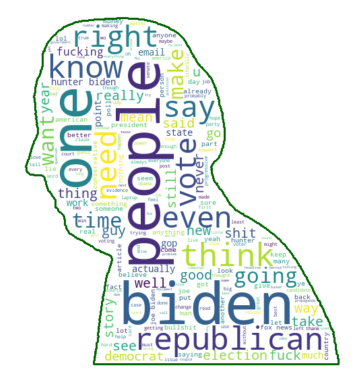

In [29]:
Biden_mask = np.array(Image.open("Illustrations/Biden_silhouette_background.png"))
wcB = WordCloud(background_color="white", 
                      mask=Biden_mask,
                      contour_width=3, 
                      repeat=True,
                      min_font_size=3,
                      contour_color='darkgreen').generate(TBC_j)
plt.figure(figsize=(10,4))
plt.imshow(wcB, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()
#wcB.to_file('WordCloud_Biden.png')

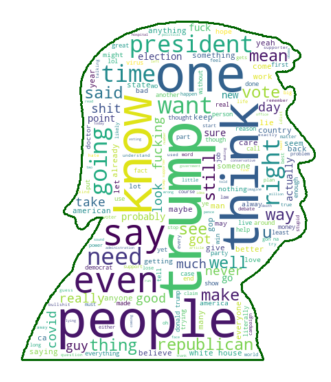

In [30]:
Trump_mask = np.array(Image.open("Illustrations/Trump_silhouette_background.png"))
wcT = WordCloud(background_color="white", 
                      mask=Trump_mask,
                      contour_width=3, 
                      repeat=True,
                      min_font_size=3,
                      contour_color='darkgreen').generate(TTC_j)
plt.figure(figsize=(10,4))
plt.imshow(wcT, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()
#wcT.to_file('WordCloud_Trump.png')

# Validation of dictionary based methods
In order for it to work, the rule-of-thumb is to have at least 10.000 tokens per document. We group them daily over the period and plot it with the desired cutoff. 

In [31]:
com_data['date'] = com_data.index
com_data['day'] = com_data['date'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d'))
documents_per_day = com_data.groupby("day").tokens.sum()

In [32]:
for i in tqdm(range(len(documents_per_day))):
    #Remove gt's and amp's
    c1 = documents_per_day[i].count('gt')
    c2 = documents_per_day[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            documents_per_day[i].remove('gt')
            documents_per_day[i].remove('amp')
        except Exception:
            pass
        
    #Remove nothings ''
    c3 = documents_per_day[i].count('')
    for j in range(0,c3):
        try:
            documents_per_day[i].remove('')
        except Exception:
            pass

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  9.03it/s]


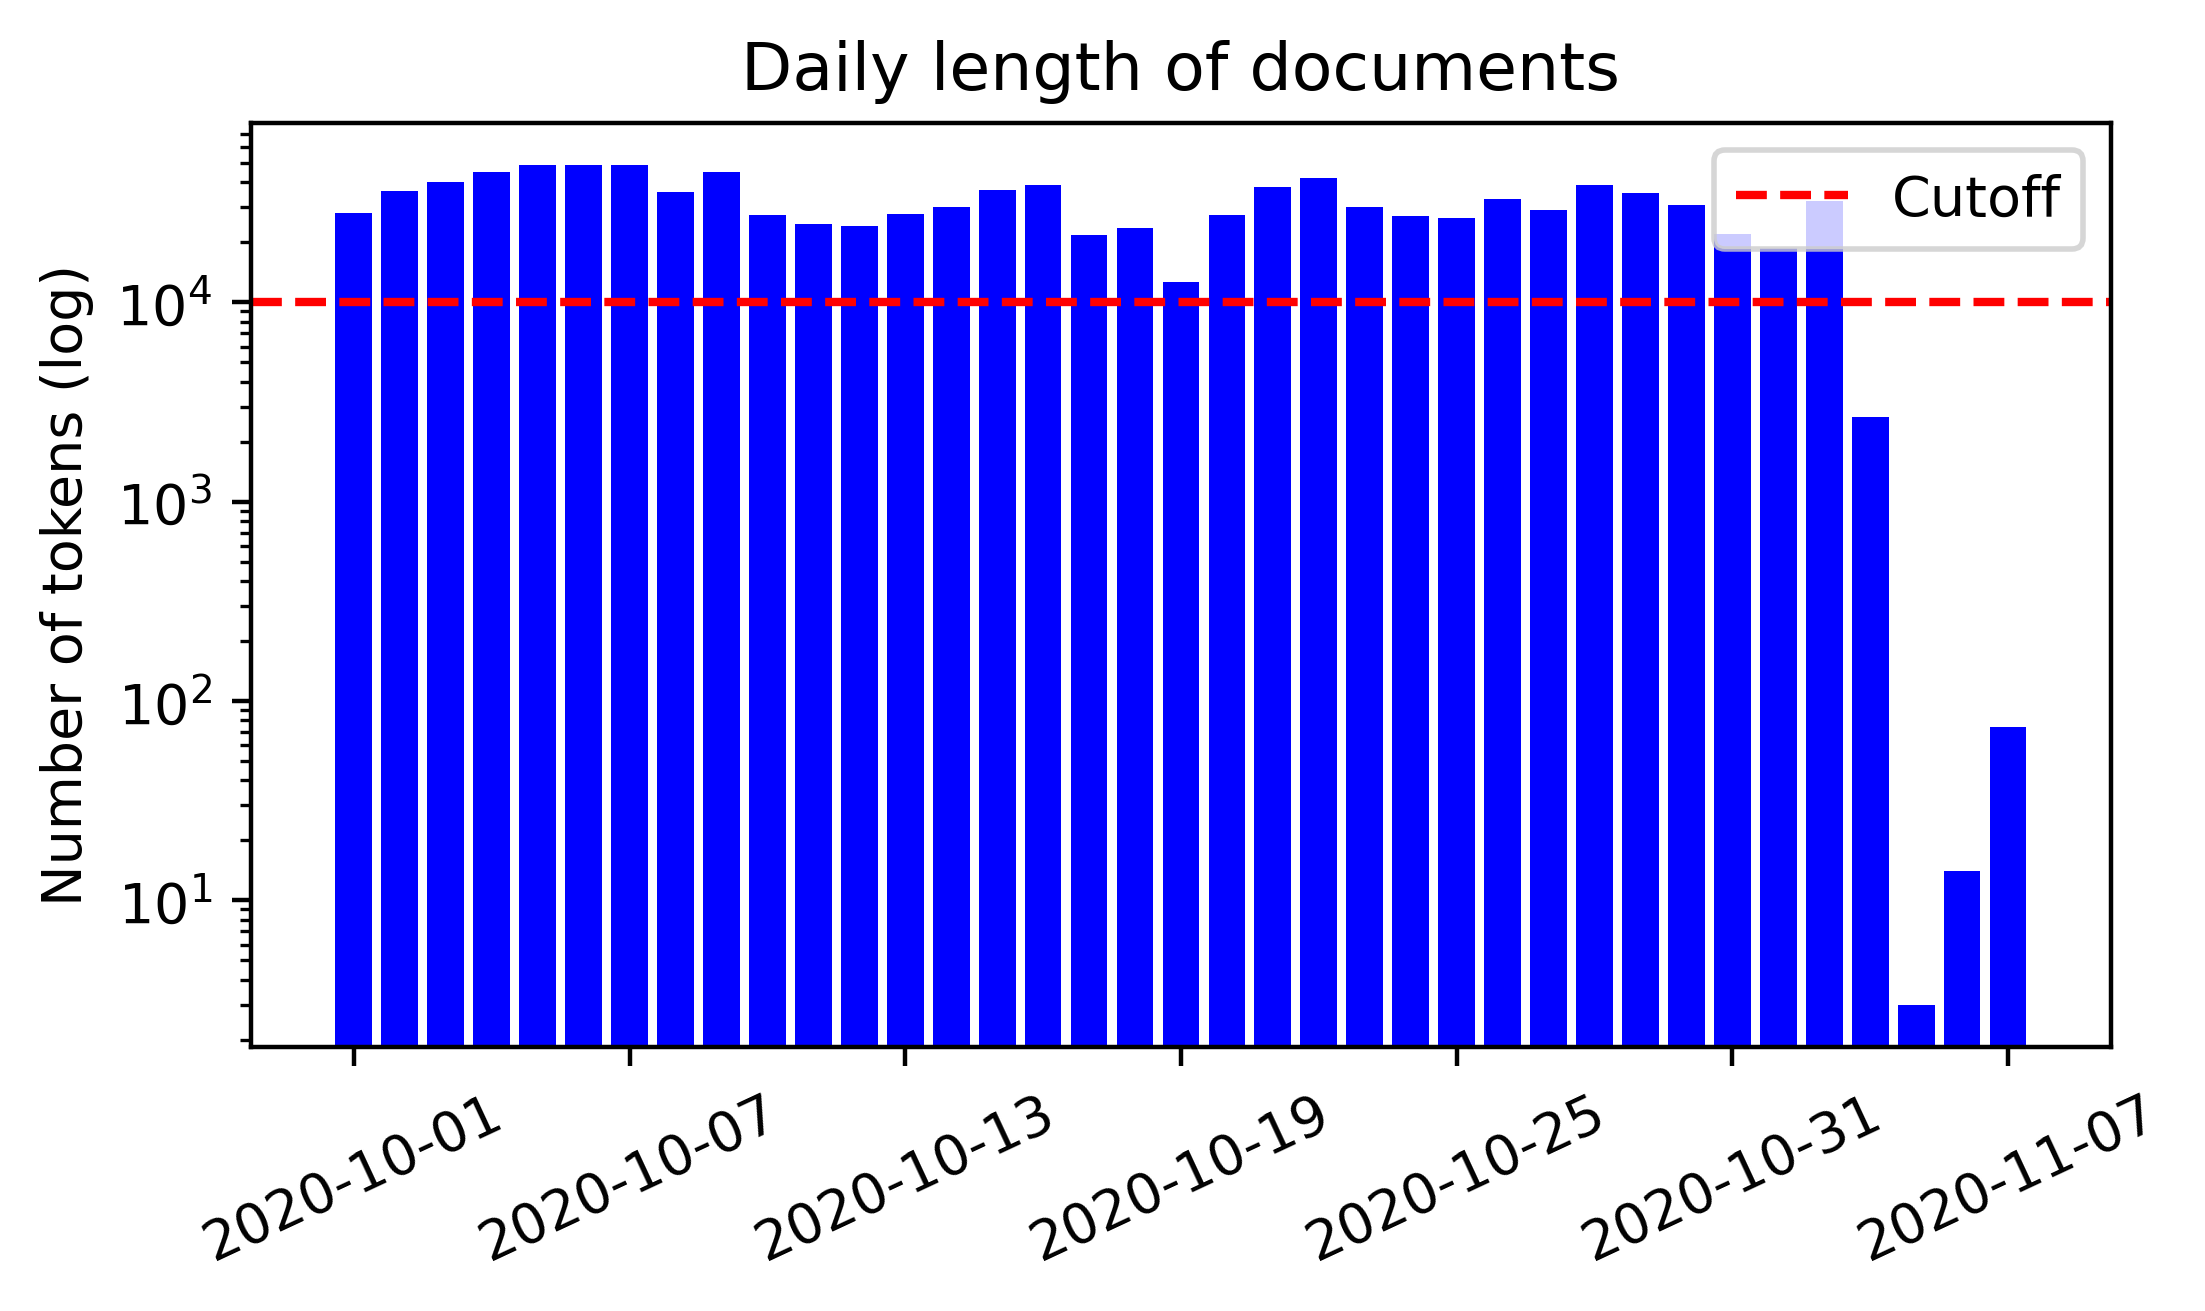

In [33]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
#plt.xticks(rotation='vertical')
ax.bar(documents_per_day.index, [len(doc) for doc in documents_per_day], color= "b")
ax.set_title("Daily length of documents")
ax.axhline(10000, color="r", linestyle="dashed", label="Cutoff")
ax.set_ylabel("Number of tokens (log)")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.xticks(rotation = 25)
ax.set_yscale('log')
ax.legend()
plt.show()

We disregard the last 3 days in the analysis going forward, partially due to them not living up to the criteria for the methods used, but also due to the difference in comments each day for each candidate, ie. Trump has comments on 2020-11-04, while Biden does not, whereas the reverse is true for 2020-11-04.

# Happiness scores using the Hedonometer lexicon.
We load in the Hedonometer data regarding happiness scores for words and apply it in the analysis of the daily documents in the corpus.

In [34]:
labMT = pd.read_csv(r"C:\Users\JaQtae\Desktop\SocInfo2022\Hedonometer.csv", index_col="Word")
setup_mpl()

In [35]:
def hscore(tokens, p=False):
    #Iterative counter
    # If we want print p = True.
    score = 0
    freq_dict = dict(nltk.FreqDist(tokens))
    freq_norm = 0
    for word in tokens:
        # Count for word in dict
        try:
            score += labMT.loc[[word]]["Happiness Score"].values[0] * freq_dict[word]
            freq_norm += freq_dict[word]
        except:
            #Doesnt exist in labMT
            None
    hscore = score / (freq_norm+1e-06) #NaN for 0-division
    if p==True:
        return print("Happiness score: {}".format(hscore))
    else:
        return hscore

In [36]:
temp = com_data.groupby(['day', 'politician']).tokens.sum()
for i in tqdm(range(len(temp))):
    #Removal of webscrape nonsense
    c1 = temp[i].count('gt')
    c2 = temp[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            temp[i].remove('gt')
            temp[i].remove('amp')
        except Exception:
            pass

    c3 = temp[i].count('')
    for j in range(0,c3):
        try:
            temp[i].remove('')
        except Exception:
            pass

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 23.94it/s]


In [40]:
P_daily_hscore = temp.progress_apply(lambda x: hscore(x))
P_daily_hscore.index = temp.index

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [07:46<00:00,  6.47s/it]


### Here we redefine the dataset to another format that is more maleable, ie. pandas dataframes with the indexing wanted.

In [41]:
B_hscores = []
T_hscores = []
for q in range(len(P_daily_hscore)):
    if P_daily_hscore.index[q].count('Biden') == 1:
        B_hscores.append(P_daily_hscore[q])
    elif P_daily_hscore.index[q].count('Trump') == 1:
        T_hscores.append(P_daily_hscore[q])
    else:
        pass
#Sanity check
len(B_hscores) == len(T_hscores)

True

In [42]:
df_B = pd.DataFrame()
df_T = pd.DataFrame()
df_B['B_hscore'] = B_hscores
df_T['T_hscore'] = T_hscores

In [43]:
catcher = []
tester = []
for k in range(len(P_daily_hscore)):
    if P_daily_hscore.index[k].count('Biden') == 1:
        catcher.append(P_daily_hscore.index[k][0])
    elif P_daily_hscore.index[k].count('Trump') == 1:
        tester.append(P_daily_hscore.index[k][0])

The values are dropped in correspondence with the previous comments regarding cut-off of the tail end of the dictionary based methodology criterium.

In [44]:
del catcher[-2:]
del tester[-2:]
df_B.drop(df_B.tail(2).index,inplace=True)
df_T.drop(df_T.tail(2).index,inplace=True)
df_B.index = catcher

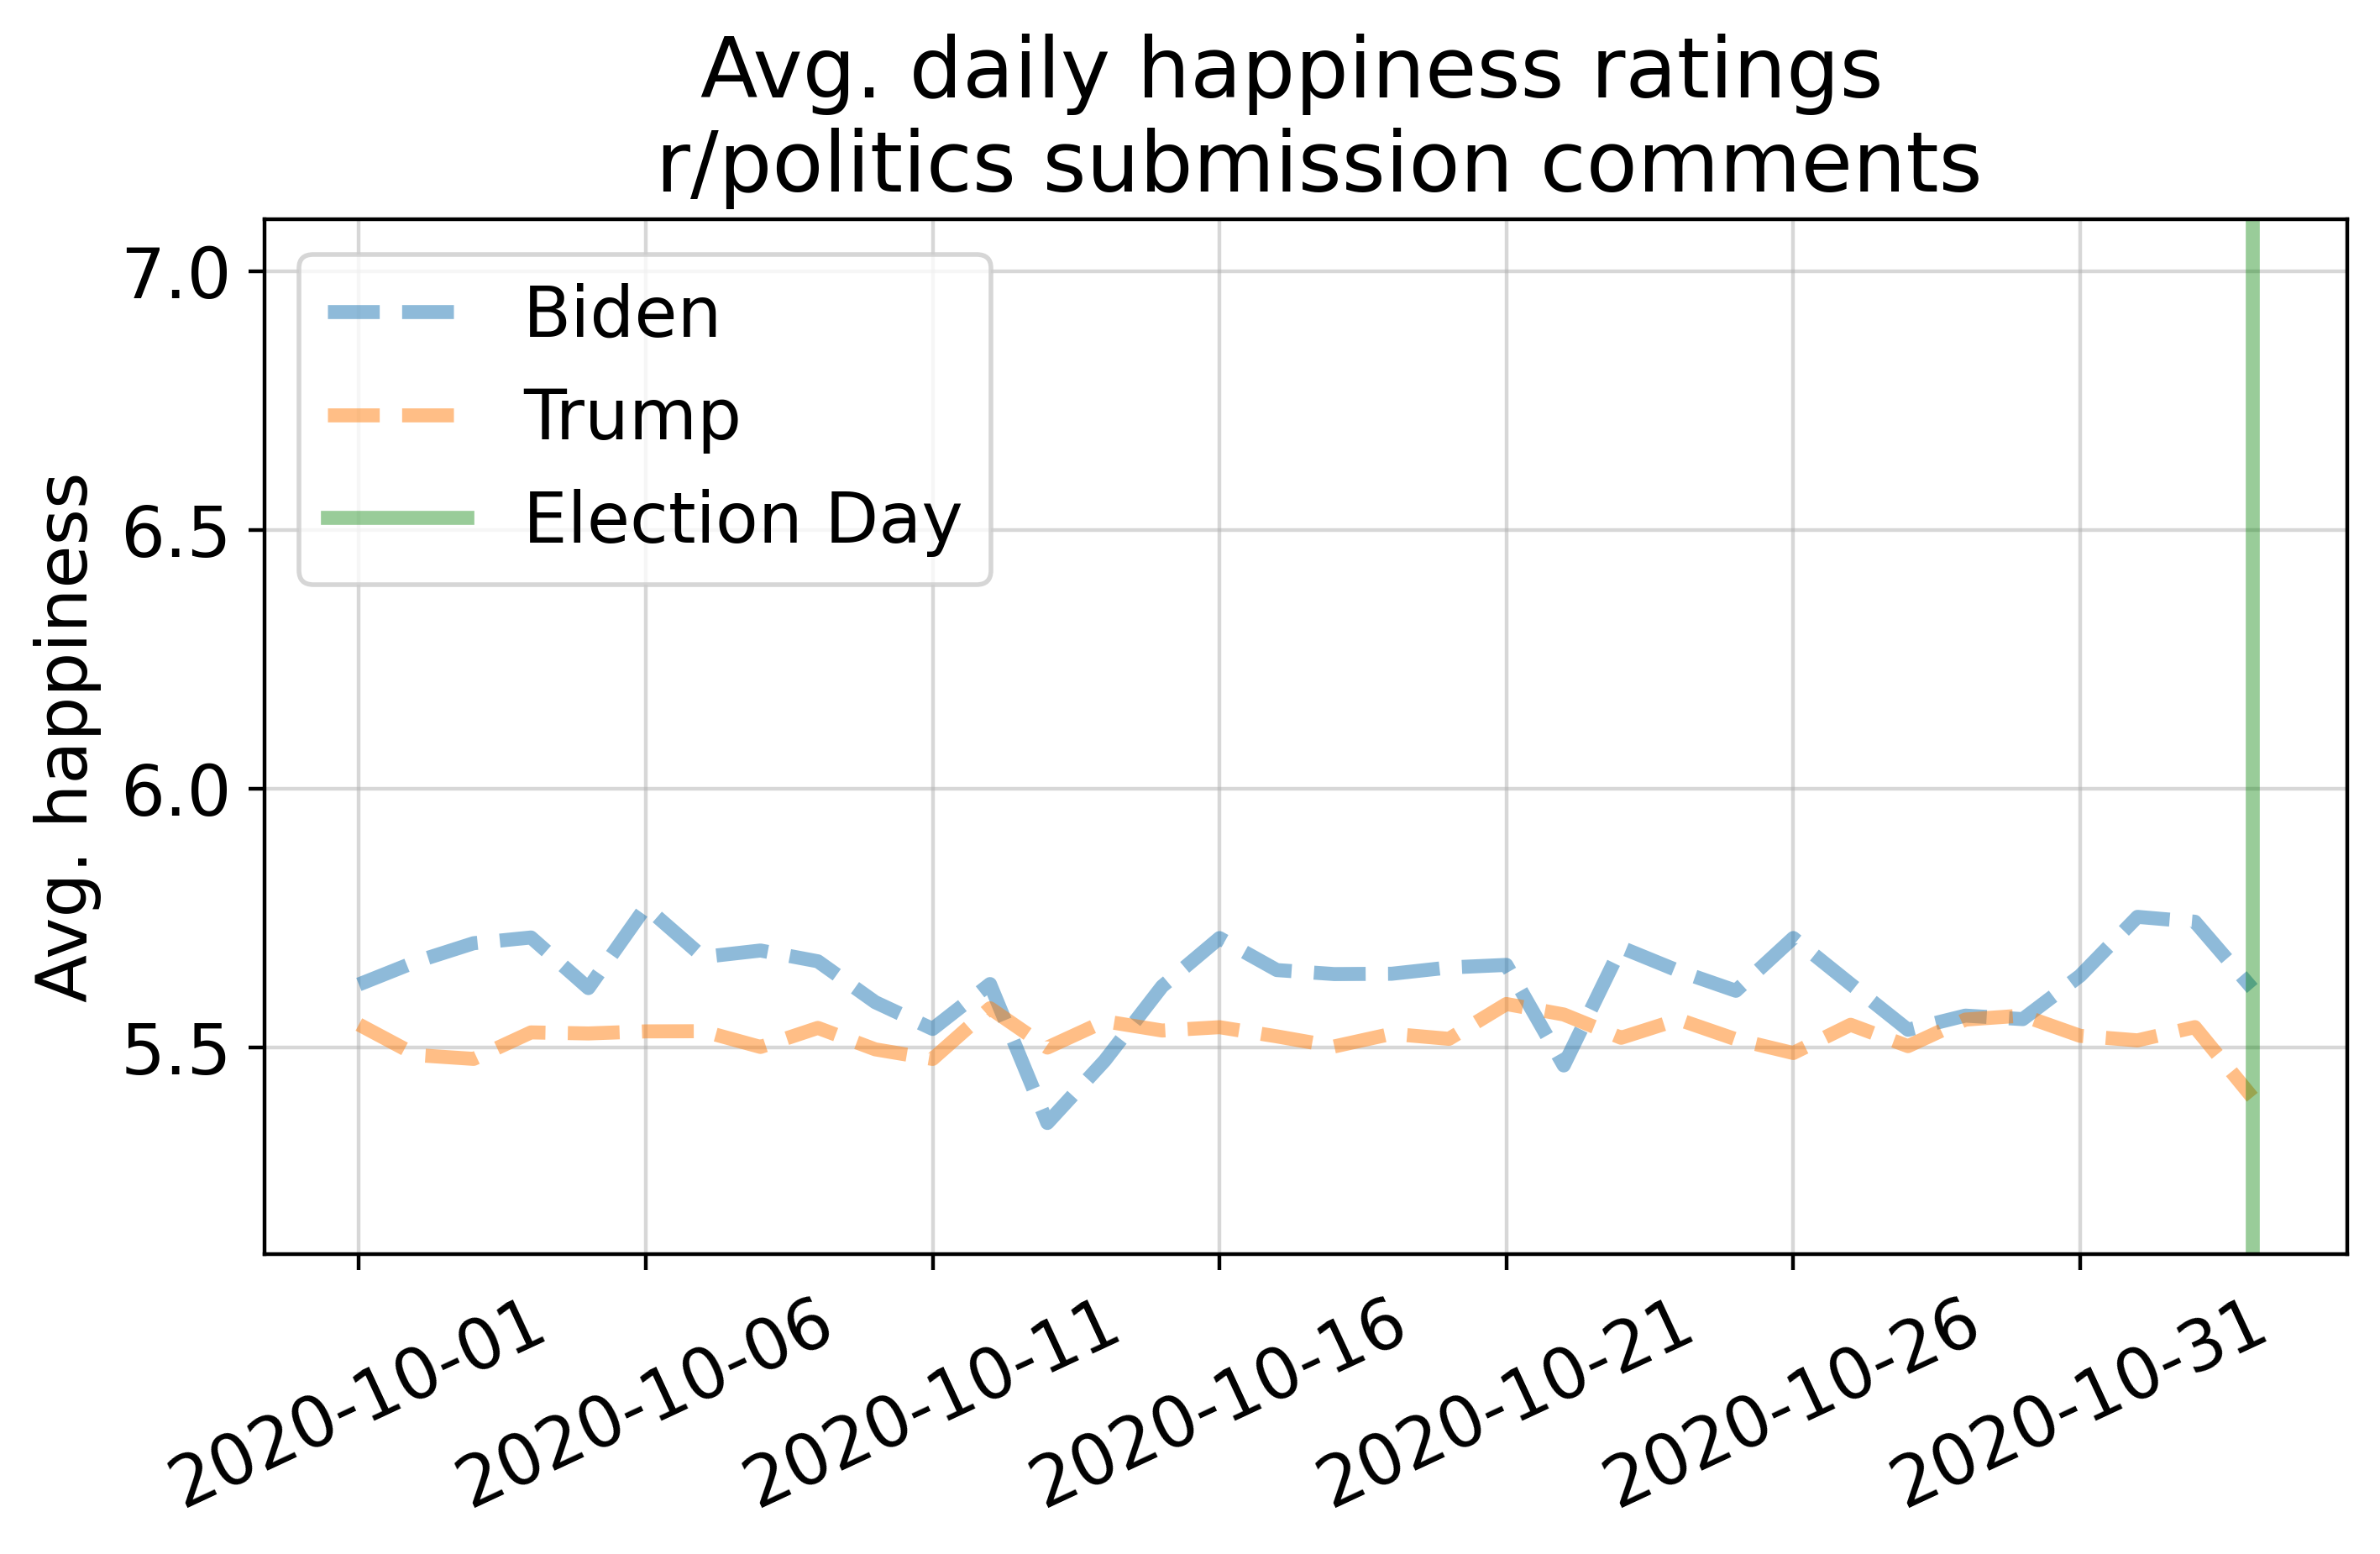

In [45]:
fig, ax = plt.subplots(figsize=(8,4), dpi=400)
ax.plot(df_B.index, df_B, ls = "--", alpha = 0.5, label='Biden')
ax.plot(df_T.index, df_T, ls = "--", alpha = 0.5, label='Trump')
plt.axvline(x=df_B.index[-1], color='green', alpha = 0.4, label='Election Day')
ax.set_title("Avg. daily happiness ratings \n r/politics submission comments")
ax.set_ylabel("Avg. happiness")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
plt.xticks(rotation = 25)
plt.ylim(5.1,7.1)
plt.grid(alpha=0.5)
ax.legend()
plt.show()

# Word Shifterator plots
We chose the election day as the day to remark upon, and compare it to the whole previous part of the dataset to investigate changes of sentiment over time. This amounts to a total of 33 days contained in the reference dictionary.

In [46]:
election_day = P_daily_hscore.index[-5][0]
print('Election day is: {}'.format(election_day))
d_T = datetime.strptime(P_daily_hscore.index[-5][0], '%Y-%m-%d')
d_m = (d_T- dt.timedelta(days=33)).strftime('%Y-%m-%d') #string format

Election day is: 2020-11-03


In [47]:
l = documents_per_day.loc[election_day]
l_ref = np.concatenate(documents_per_day[(documents_per_day.index < election_day) & \
                                (documents_per_day.index > d_m)].values)

In [50]:
p_l = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_lref = dict([(item[0], item[1]/len(l)) for item in Counter(l_ref).items()])
sorted(p_lref.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 7.258979206049149),
 ('like', 3.2827977315689982),
 ('people', 3.255954631379962),
 ('would', 2.942533081285444),
 ('get', 2.0862003780718337),
 ('one', 2.0139886578449904),
 ('even', 1.662381852551985),
 ('going', 1.6544423440453686),
 ('think', 1.6351606805293006),
 ('know', 1.5497164461247637)]

In [51]:
sorted(p_l.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 0.0166351606805293),
 ('would', 0.010964083175803403),
 ('like', 0.00945179584120983),
 ('people', 0.008695652173913044),
 ('prison', 0.006427221172022685),
 ('right', 0.005671077504725898),
 ('go', 0.005671077504725898),
 ('vote', 0.005671077504725898),
 ('think', 0.004914933837429111),
 ('get', 0.004914933837429111)]

So the main topic surrounds trump and people, however on the day of election voting seems to be more significant, understandably so.

In [52]:
# [(token, diff(p_l, p_lref))]
# Do it for every word in the union of sets of words for corpora
d_p = dict([(token, p_l.get(token, 0) -  p_lref.get(token, 0)) \
               for token in set(p_l.keys()).union(set(p_lref.keys()))])
labMT_dict = pd.Series(labMT["Happiness Score"].values, index=labMT.index).to_dict()
prep_hscore =  dict([(token, labMT_dict.get(token, np.nan)-5) for token in set(p_l.keys()).union(set(p_lref.keys()))])

d_phi = dict([(token, prep_hscore[token]*d_p[token]) for token in set(p_l.keys()).union(set(p_lref.keys()))\
                    if not np.isnan(prep_hscore[token])]) #Do it for everything that isn't NaN
# Absolute value sorting top 10
sorted(d_phi.items(), key = lambda x: np.abs(x[1]), reverse=True)[:10]

[('like', -7.26682797731569),
 ('people', -3.7668204158790175),
 ('covid', 3.1454820415879015),
 ('shit', 2.4234404536862004),
 ('good', -2.278185255198488),
 ('trump', -2.1727032136105846),
 ('right', -2.033149338374291),
 ('think', -1.9562948960302462),
 ('get', -1.914782608695652),
 ('well', -1.8464120982986765)]

The $\delta\phi$ value identifies the extent a given set of words contribute to the difference in scores and how they do it. Either a word is used more often in one text over the other and its influence, positive or negative, is weighted in the relative frequency. This matches very well with the Word Cloud representation of the texts.

C:\Users\JaQtae\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


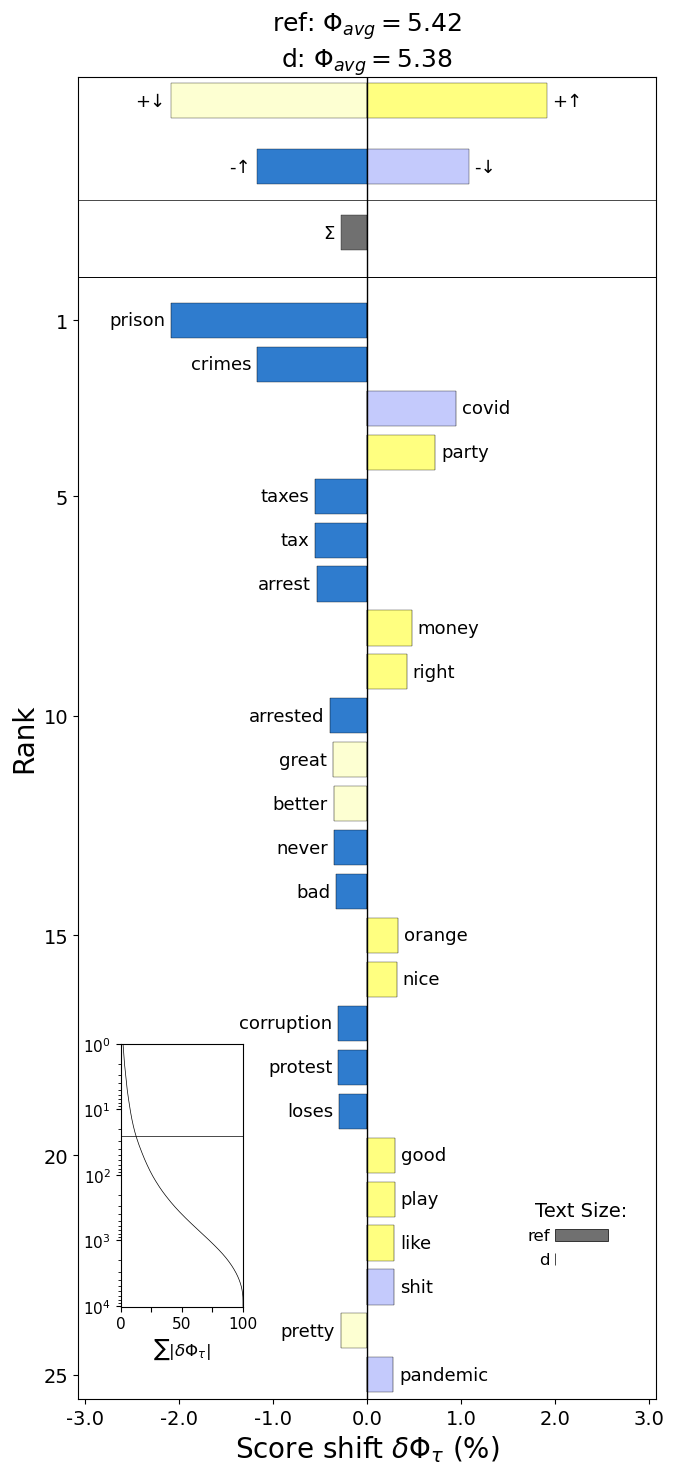

<Figure size 640x480 with 0 Axes>

In [54]:
senti_shift = sft.WeightedAvgShift(type2freq_1 = p_lref,
                                     type2freq_2 = p_l,
                                     type2score_1 = labMT_dict,
                                     reference_value = 5)
senti_shift.get_shift_graph(detailed = True,
                            system_names = ['ref', 'd'],
                            top_n=25)
                            #filename='shifteratorGraph.svg')

# Networks science tools

# 4 Discussion

### What is still missing?

### What could be improved?

It would undoubtedly have been interesting to investigate the political content on r/politics over a longer time period, e.g. six months preceeding the election day, which would allow for the detection of longer term trends in redditor activity and sentiment. For such a scope to be feasible, bigger computational muscles than what the group members had at their disposal. 